In [1]:
import numpy as np
import mne
import scipy.signal as sg
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import seaborn as sns
import stumpy

c:\Users\rafar\miniconda3\envs\torch_env\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Load Data Information

In [2]:
#Load a single patient that will be used for analysis
file = "./DatabaseSubjects\subject1.edf"
anno = "./DatabaseSubjects/HypnogramAASM_subject1.txt"
#anno = "C:/Users/Rafael Arone/DOwnloads/c52a34.csv"
data = mne.io.read_raw_edf(file, preload=True)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names
print("Loaded")

Extracting EDF parameters from c:\Users\rafar\Documents\2024\Disciplina - Machine Learning Para séries Temporais\Trabalho1\DatabaseSubjects\subject1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\rafar\AppData\Local\Temp\ipykernel_40988\1430877535.py:5: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf(file, preload=True)
c:\Users\rafar\miniconda3\envs\torch_env\lib\site-packages\mne\io\edf\edf.py:782: RuntimeWarning: All-NaN axis encountered
  value = np.nanmax([_prefilter_float(x) for x in values])
C:\Users\rafar\AppData\Local\Temp\ipykernel_40988\1430877535.py:5: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(file, preload=True)
c:\Users\rafar\miniconda3\envs\torch_env\lib\site-packages\mne\io\edf\edf.py:784: RuntimeWarning: All-NaN axis encountered
  value = np.nanmin([_prefilter_float(x) for x in values])


Reading 0 ... 5767999  =      0.000 ... 28839.995 secs...
Loaded


In [45]:
class_name_alias = {
    0: 'dont_care',
    1: 'N3',
    2: 'N2',
    3: 'N1',
    4: 'REM',
    5: 'A',
}

In [3]:
##Read annotations from the txt file with single column
def read_annotations(file):
    with open(file, 'r') as f:
        annotations = f.readlines()
    annotations = [int(x.strip()) for x in annotations[1:]]
    return annotations

annotations = read_annotations(anno)


In [4]:
#Dataset information
info

<Info | 8 non-empty values
 bads: []
 ch_names: ECG, FP1-A2, CZ-A1, EMG1, EOG1, VTH, VAB, NAF2P-A1, NAF1, PHONO, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2002-05-29 22:55:00 UTC
 nchan: 23
 projs: []
 sfreq: 200.0 Hz
 subject_info: 3 items (dict)
>

In [5]:
fs = info['sfreq'] #Hz
segmentation_size = 5*fs #30 seconds
num_channels = len(channels)

In [24]:
##Perform filtering to downsample
#Filter until 25Hz to downsample in 50Hz (Nyquist frequency)
#We are saying that we are only interested in the patterns that are below 25Hz
fs = int(info['sfreq']) #Hz
segmentation_size = 5*fs #30 seconds
data.filter(0.5, 25, fir_design='firwin')
raw_data = data.get_data()
#Downsample from 200Hz to 50Hz
raw_data = sg.decimate(raw_data, 4, axis=1)
fs = fs/4


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    8.6s


In [25]:
print(channels)

['ECG', 'FP1-A2', 'CZ-A1', 'EMG1', 'EOG1', 'VTH', 'VAB', 'NAF2P-A1', 'NAF1', 'PHONO', 'PR', 'SAO2', 'PCPAP', 'POS', 'EOG2', 'O1-A2', 'FP2-A1', 'O2-A1', 'CZ2-A1', 'EMG2', 'PULSE', 'VTOT', 'EMG3']


In [32]:
#We want all the data from the channels that are not EOG or ECG
interst_channels = ['EOG1', 'EOG2', 'FP1-A2', 'CZ-A1', 'O1-A2']

In [29]:
indexes  = [channels.index(x) for x in interst_channels]
#Remove the last 30 minutes of data
raw_data = raw_data[indexes][..., :-int(30*60*fs)]

In [40]:
raw_data.shape

(8, 1352000)

In [42]:
gt = np.array(annotations)
#Remove the last hout
gt = gt[:-int(30*60/5)]

In [43]:
gt.shape

(5408,)

In [30]:
#Perform the z-normalization
channel_means = np.mean(raw_data, axis=1)   
channel_std = np.std(raw_data, axis=1)
raw_data = (raw_data - channel_means[:, np.newaxis])/channel_std[:, np.newaxis]

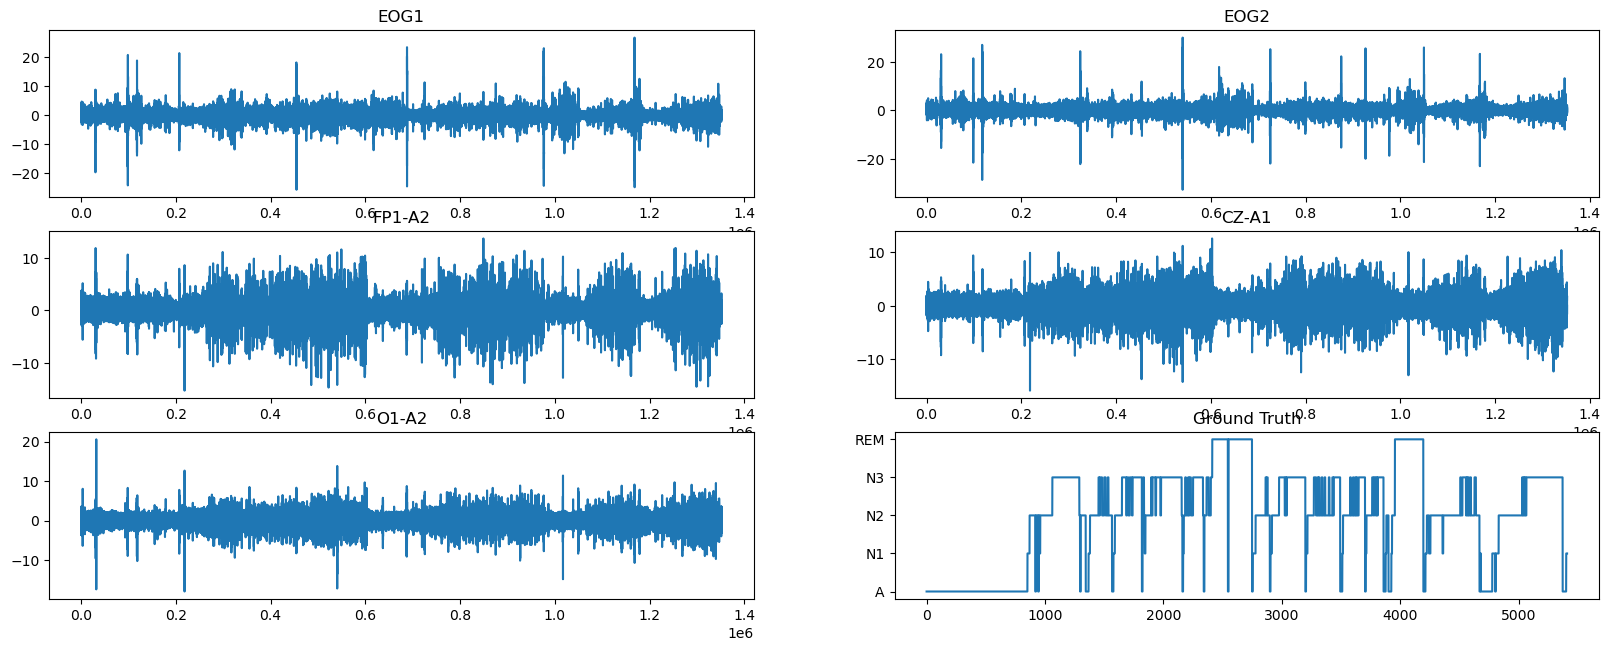

In [46]:
#Plot all data, one in each subplot
plt.figure(figsize=(20,10))
for i in range(len(interst_channels)):
    plt.subplot(4,2,i+1)
    plt.plot(raw_data[i])
    plt.title(interst_channels[i])
#Plot the annotations
#Change the name of the stages to the ones that are in the AASM manual using the dict
gt = np.array([class_name_alias[x] for x in gt])
plt.subplot(4,2,len(interst_channels)+1)
plt.plot(gt)
plt.title("Ground Truth")

plt.show()

In [ ]:
#Analysis using matrix profile
#Perform multi-channel matrix profile
m = int(2*fs) #Window size
matrix_profile = stumpy.mstump(raw_data, m=m, normalize=True)



In [ ]:
matrix_profile

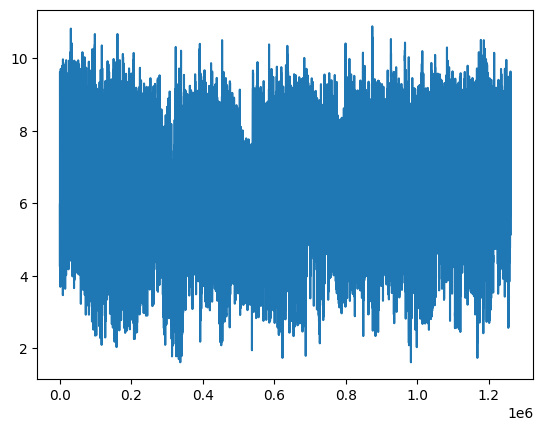

In [ ]:
#Plot matrix profile
plt.plot(out[:,0])


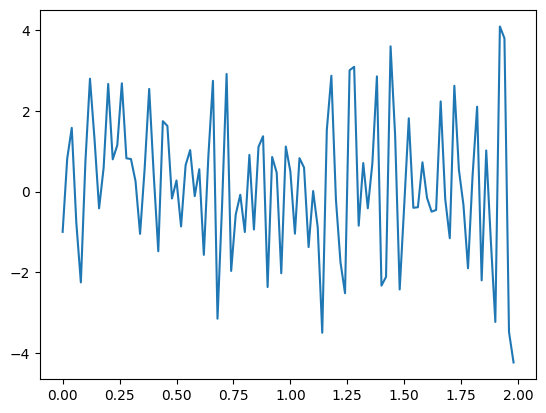

In [ ]:
#Get the discord (position of the most anomalous segment)
discord = np.argmax(out[:,0])	
t = np.arange(0,segmentation_size)/fs
plt.plot(t,channel[discord:discord+segmentation_size])

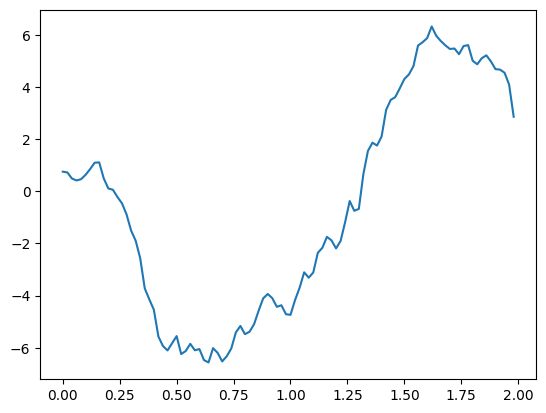

In [ ]:
#Plot one motif
motif = np.argmin(out[:,0])
plt.plot(t,channel[motif:motif+segmentation_size])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')



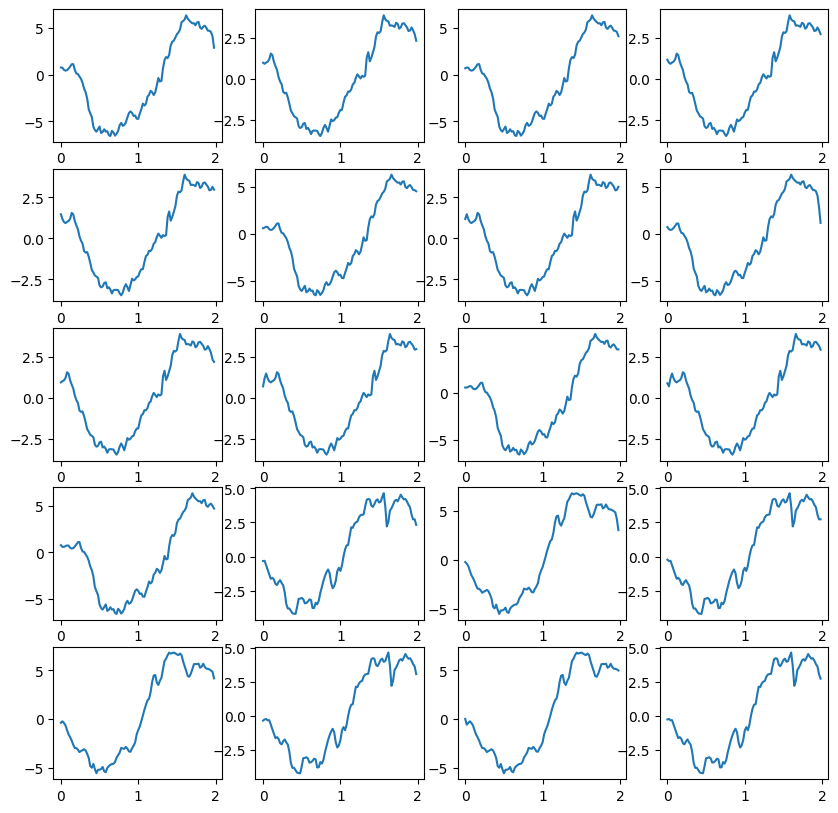

In [ ]:
#Plot the first 10 motifs
motifs = np.argsort(out[:,0])[0:20]
fig, axs = plt.subplots(5, 4, figsize=(10, 10))
axs = axs.ravel()
for i in range(20):
    axs[i].plot(t,channel[motifs[i]:motifs[i]+segmentation_size])
plt.show()


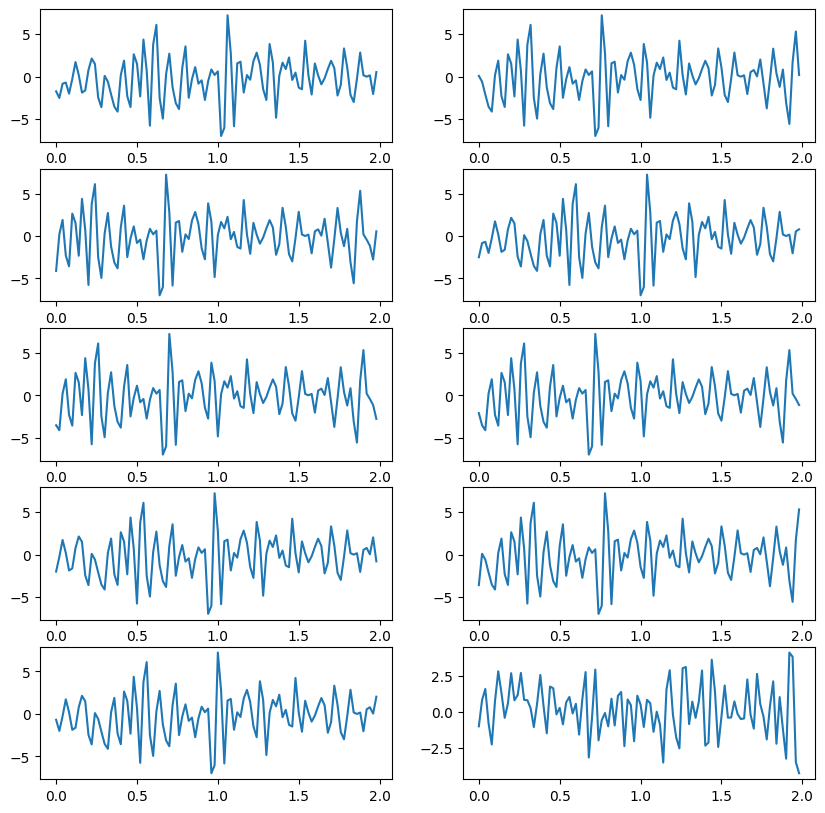

In [ ]:
#Plot the first 10 discords
discords = np.argsort(out[:,0])[-10:]
fig, axs = plt.subplots(5, 2, figsize=(10, 10))
axs = axs.ravel()
for i in range(10):
    axs[i].plot(t,channel[discords[i]:discords[i]+segmentation_size])
plt.show()


In [ ]:
out

mparray([[5.957885729557115, 288629, -1, 288629],
         [5.907706157317241, 288630, -1, 288630],
         [5.917423289779149, 288630, -1, 288630],
         ...,
         [6.037068780113219, 365764, 365764, -1],
         [6.090296673242561, 365765, 365765, -1],
         [6.1284323559908165, 365766, 365766, -1]], dtype=object)

In [ ]:
#Get different motifs, for the motifs similiar to the first one add a oofset, and recalculate the motifs, until we reach 10 different mmotifs
out_new = out.copy()
base_motifs = []
num_diff_motifs = 20
offset_to_add = 20
passed_motifs = []

def change_motif_offset(out_new, index_motif, offset_to_add, depth = 0, max_depth = 50):
    #Get motifs similar to the base motif by using the second from out_new
    #Check for the left and right indexes motifs
    if depth > max_depth:
        return
    if index_motif in passed_motifs[-1]:
        return
    left_index = out_new[index_motif, 2]
    right_index = out_new[index_motif, 3]
    out_new[index_motif, 0] = np.inf
    passed_motifs[-1].append(index_motif)
    #Get unique indexes that are not -1
    indexes_to_check = np.unique(np.concatenate((np.array([left_index]), np.array([right_index]))))
    indexes_to_check = indexes_to_check[indexes_to_check != -1]
    #Remove the passed motifs
    indexes_to_check = np.setdiff1d(indexes_to_check, passed_motifs[-1])

    for index in indexes_to_check:
        change_motif_offset(out_new, index, offset_to_add, depth+1, max_depth)

for i in range(num_diff_motifs):
    index_motif = np.argmin(out_new[:,0])
    base_motifs.append(index_motif)
    passed_motifs.append([])
    print(i)

    change_motif_offset(out_new, index_motif, offset_to_add)
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


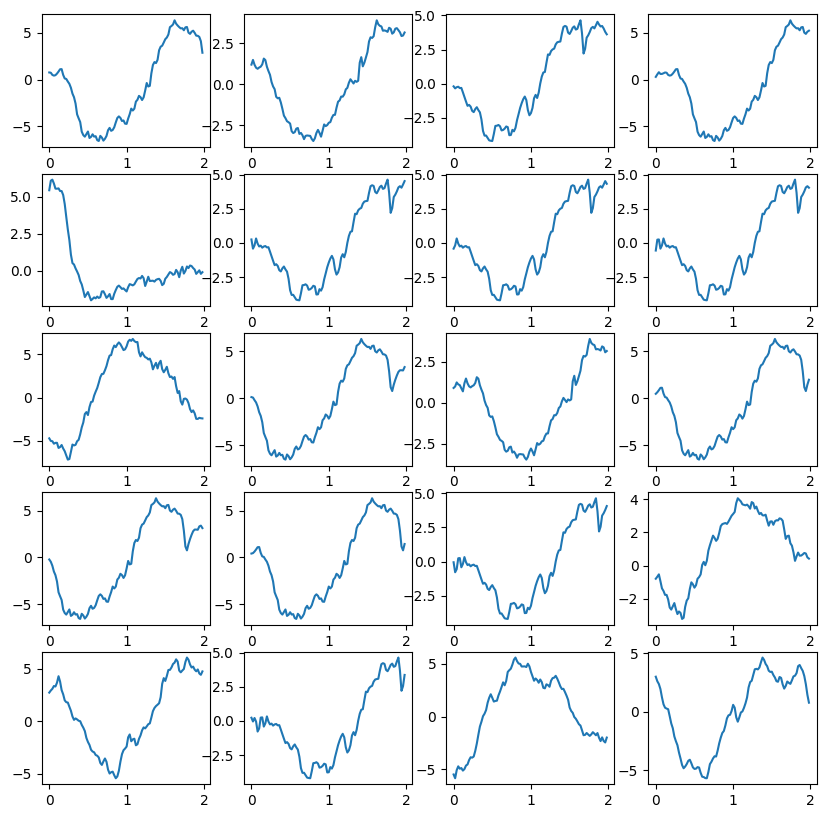

In [ ]:
#Plot the base motifs
fig, axs = plt.subplots(5, 4, figsize=(10, 10))
axs = axs.ravel()
for i in range(20):
    axs[i].plot(t,channel[base_motifs[i]:base_motifs[i]+segmentation_size])
plt.show()


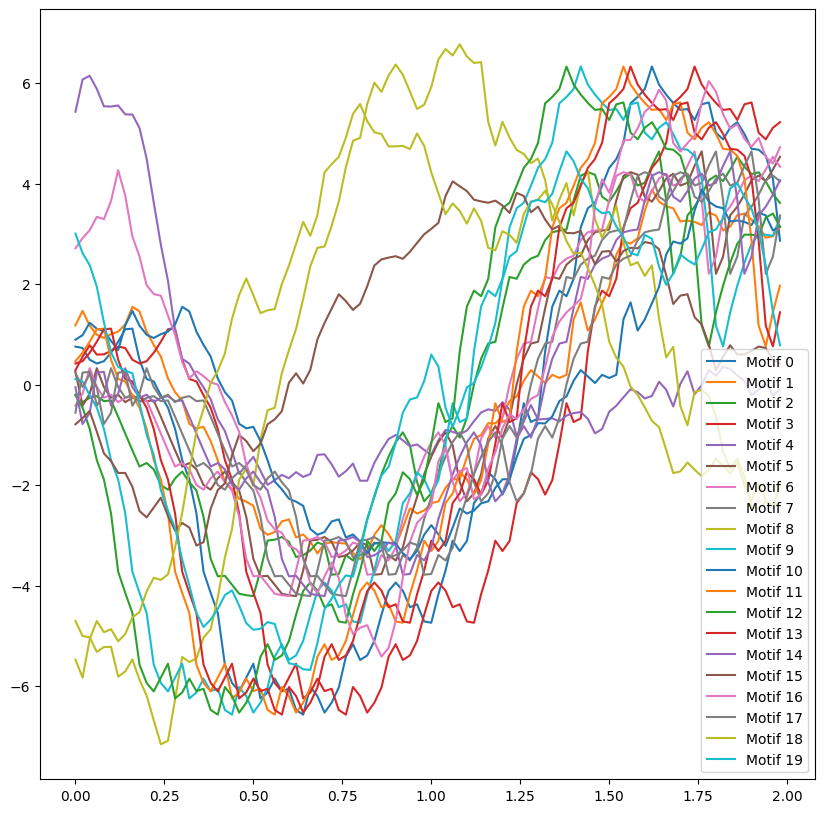

In [ ]:
#Plot all in the same graph
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(20):
    ax.plot(t,channel[base_motifs[i]:base_motifs[i]+segmentation_size])
    ax.legend(["Motif "+str(i) for i in range(20)])
plt.show()

In [ ]:
#Find the classes from the gt where each motif belongs
classes_by_motif_cluster = []
for passed_motifs_i in passed_motifs:
    classes = []
    for motif in passed_motifs_i:
        classes.append(annotations[int(motif/(30*fs))])
    classes_by_motif_cluster.append(classes)

In [ ]:
len(classes)

24950

In [ ]:
motif/(30*fs)

410.0706666666667

In [ ]:
#Count the number of each class for each motif cluster
count_classes = []
for classes in classes_by_motif_cluster:
    count_classes.append(np.unique(classes, return_counts=True))

In [ ]:
np.unique(classes_by_motif_cluster[2])

array([5])

In [ ]:
len(classes_by_motif_cluster[2])

25696

In [ ]:
count_classes

[(array([5]), array([23145], dtype=int64)),
 (array([5]), array([30962], dtype=int64)),
 (array([5]), array([25696], dtype=int64)),
 (array([5]), array([26202], dtype=int64)),
 (array([5]), array([24422], dtype=int64)),
 (array([5]), array([25181], dtype=int64)),
 (array([5]), array([34476], dtype=int64)),
 (array([5]), array([25182], dtype=int64)),
 (array([5]), array([25800], dtype=int64)),
 (array([5]), array([19717], dtype=int64)),
 (array([5]), array([26210], dtype=int64)),
 (array([5]), array([28092], dtype=int64)),
 (array([5]), array([25181], dtype=int64)),
 (array([5]), array([21362], dtype=int64)),
 (array([5]), array([21364], dtype=int64)),
 (array([5]), array([25007], dtype=int64)),
 (array([5]), array([24335], dtype=int64)),
 (array([5]), array([25695], dtype=int64)),
 (array([5]), array([25695], dtype=int64)),
 (array([5]), array([24950], dtype=int64))]

In [ ]:
int(base_motifs[i]/fs)

6739

In [ ]:
base_motifs

[336963,
 336959,
 336975,
 336977,
 313827,
 334279,
 337337,
 334278,
 334281,
 537506,
 335224,
 158593,
 334282,
 334283,
 334284,
 334274,
 334953,
 330962,
 330961,
 330963]